In [1]:
library(grid)
library(rpart)
library(rpart.plot)
library(partykit)
library(lattice)
library(ggplot2)
library(caret)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
set.seed(1)

In [3]:
jRoadType <- c("都市間高速", "都市高速", "有料道路", "国道", "県道", "主要地方道", "一般道1、一般道2、一般道3", "その他")
jHighSpeeds <- c("都市間高速", "都市高速", "有料道路")

In [4]:
printf <- function(...) cat(sprintf(...))

In [5]:
# valid columns when high speed
invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'RoadType', 'flag')
isValidColumn <- function(x) ! x %in% invalids

In [6]:
CV <- function(dfx, expr, verbose=FALSE) {        
    folds <- createFolds(dfx$flag, k=5)
    
    count <- 1
    errs <- c()
    reds <- c()
    blues <- c()
    for (ids in folds) {
        train <- dfx[-ids, ]
        test <- dfx[ids, ]
        # fit <- rpart(expr, data=train, method="class")
        fit <- rpart(expr, data=train, method="class", cp=0.022)
        p <- predict(fit, newdata=test)
        predictedFlags <- colnames(p)[max.col(p, ties.method = "first")]
        
        if (verbose) {
            printf("Fold%d\n", count)
            result <- correctVsPredict(test, predictedFlags, verbose)
            reds <- c(reds, result[1])
            blues <- c(blues, result[2])
            count <- count + 1
            printf("\n")
        } else {
            result <- correctVsPredict(test, predictedFlags, verbose)
            reds <- c(reds, result[1])
            blues <- c(blues, result[2])
        }
        
        nerr <- sum((predictedFlags == test$flag) == FALSE)
        errs <- c(errs, nerr / nrow(test))
    }
    
    return(c(mean(errs), mean(reds), mean(blues)))
}

In [7]:
correctVsPredict <- function(test, predictedFlags, verbose=FALSE) {    
    # for All
    # nTests <- nrow(test)
    # nCorrectAll <- sum((predictedFlags == test$flag) == TRUE)
    # printf("As fo All: correct/all = %d/%d = %f\n", nCorrectAll, nTests, nCorrectAll / nTests)
    
    # for Red
    predictedRedRows <- test[predictedFlags == "Red", ]
    nCorrectReds <- sum((predictedRedRows$flag == 'Red') == TRUE)
    nPredictedReds <- nrow(predictedRedRows)
    
    # for Blue
    predictedBlueRows <- test[predictedFlags == "Blue", ]
    nCorrectBlues <- sum((predictedBlueRows$flag == 'Blue') == TRUE)
    nPredictedBlues <- nrow(predictedBlueRows)
        
    if (verbose) {
        printf("As for Red: correct/predict = %d/%d = %f\n", nCorrectReds, nPredictedReds, nCorrectReds / nPredictedReds)
        printf("As for Blue: correct/predict = %d/%d = %f\n", nCorrectBlues, nPredictedBlues, nCorrectBlues / nPredictedBlues)  
    }    
    
    c(nCorrectReds/nPredictedReds, nCorrectBlues/nPredictedBlues)
}

In [8]:
printRedRatios <- function(dfx) {
    nRed <- nrow(dfx[dfx$flag == "Red", ])
    nAll <- nrow(dfx)
    printf("Red/All = %d/%d = %f\n", nRed, nAll, nRed/nAll)
    printf("1 - Red/All = %d/%d = %f\n", nAll - nRed, nAll, 1 - nRed/nAll)
}

In [9]:
createFormula <- function(invalids, allFeatures) {
    isValidColumn <- function(x) ! x %in% invalids
    
    features <- Filter(isValidColumn, allFeatures)
    return(paste("flag ~ ", paste(features, collapse=" + ")))
}

# Predict Reds

In [11]:
df3 <- read.csv("../data/middle/sp3-tmp.csv", stringsAsFactors=FALSE)

In [12]:
df3$flag[df3$flag == "RedA"] <- "Red"
df3$flag[df3$flag == "RedB"] <- "Red"
df3$flag[df3$flag == "BlueA"] <- "Blue"
df3$flag[df3$flag == "BlueB"] <- "Blue"
df3$flag <- as.factor(df3$flag)

In [13]:
allFeatures <- c(colnames(df3))

In [14]:
roadTypes <- unique(df3$RoadType)

In [15]:
for (i in roadTypes) {
    printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
    dfx <- df3[df3$RoadType == i, ]
    expr <- createFormula(invalids, allFeatures)
    result <- CV(dfx, expr, verbose=FALSE)
    printRedRatios(dfx)
    printf("Red: Mean correct/predict = %f\n", result[2])
    printf("Blue: Mean correct/predict = %f\n", result[3])
    printf("CV value: %f", result[1])
    printf("\n\n")
}

RoadType: 7 (その他)
Red/All = 25/27 = 0.925926
1 - Red/All = 2/27 = 0.074074
Red: Mean correct/predict = 0.933333
Blue: Mean correct/predict = NaN
CV value: 0.066667

RoadType: 6 (一般道1、一般道2、一般道3)
Red/All = 90/189 = 0.476190
1 - Red/All = 99/189 = 0.523810
Red: Mean correct/predict = 0.629710
Blue: Mean correct/predict = 0.627986
CV value: 0.380939

RoadType: 4 (県道)
Red/All = 36/71 = 0.507042
1 - Red/All = 35/71 = 0.492958
Red: Mean correct/predict = 0.469841
Blue: Mean correct/predict = 0.425952
CV value: 0.547619

RoadType: 5 (主要地方道)
Red/All = 154/303 = 0.508251
1 - Red/All = 149/303 = 0.491749
Red: Mean correct/predict = 0.590612
Blue: Mean correct/predict = 0.580113
CV value: 0.415847

RoadType: 3 (国道)
Red/All = 202/324 = 0.623457
1 - Red/All = 122/324 = 0.376543
Red: Mean correct/predict = 0.692106
Blue: Mean correct/predict = 0.514000
CV value: 0.367019

RoadType: 0 (都市間高速)
Red/All = 55/81 = 0.679012
1 - Red/All = 26/81 = 0.320988
Red: Mean correct/predict = 0.727735
Blue: Mean corr

In [16]:
fit3 <- rpart(expr, data=df3, method="class")

In [17]:
fit3$cptable[which.min(fit3$cptable[,"xerror"]),"CP"]

[1] 0.01002227

In [18]:
printcp(fit3)


Classification tree:
rpart(formula = expr, data = df3, method = "class")

Variables actually used in tree construction:
 [1] AheadDistance   AverageVelocity BrakeCar        Curve100       
 [5] Curve150        CurveAverage    DistManBicycle  MaxSpeed       
 [9] Pitch           RiskFactor      Speed           TimeHeadway    
[13] TimeToCollision

Root node error: 449/1042 = 0.4309

n= 1042 

        CP nsplit rel error  xerror     xstd
1 0.040831      0   1.00000 1.00000 0.035602
2 0.037862      3   0.87751 1.00445 0.035621
3 0.024499      4   0.83964 0.94878 0.035344
4 0.018931      5   0.81514 0.92428 0.035195
5 0.013363      9   0.73942 0.93541 0.035265
6 0.011136     14   0.67261 0.92873 0.035223
7 0.010022     15   0.66147 0.91982 0.035166
8 0.010000     17   0.64143 0.91982 0.035166


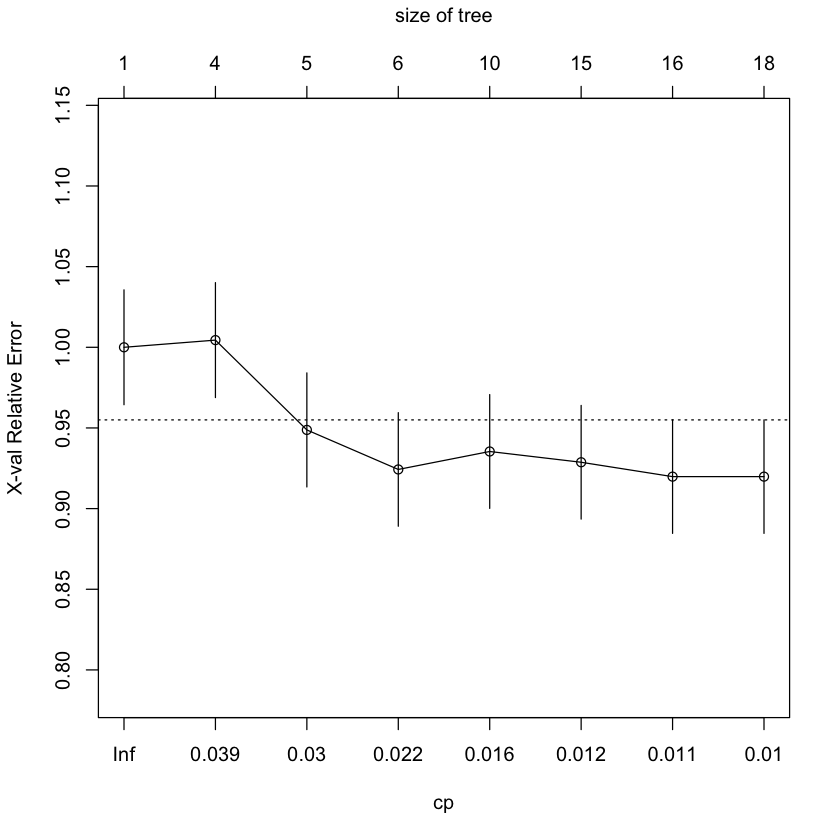

In [19]:
plotcp(fit3)

In [20]:
summary(fit3)

Call:
rpart(formula = expr, data = df3, method = "class")
  n= 1042 

          CP nsplit rel error    xerror       xstd
1 0.04083148      0 1.0000000 1.0000000 0.03560167
2 0.03786192      3 0.8775056 1.0044543 0.03562065
3 0.02449889      4 0.8396437 0.9487751 0.03534394
4 0.01893096      5 0.8151448 0.9242762 0.03519473
5 0.01336303      9 0.7394209 0.9354120 0.03526465
6 0.01113586     14 0.6726058 0.9287305 0.03522312
7 0.01002227     15 0.6614699 0.9198218 0.03516577
8 0.01000000     17 0.6414254 0.9198218 0.03516577

Variable importance
  AverageVelocity             Speed          MaxSpeed       TimeHeadway 
               10                10                 9                 9 
    AheadDistance   TimeToCollision        RiskFactor      CurveAverage 
                9                 7                 6                 6 
         Curve100          Curve150             Curve            Engine 
                6                 6                 4                 3 
            

In [21]:
set.seed(1)

In [22]:
roadTypes

[1] 7 6 4 5 3 0 2

In [23]:
i = 3
threshold <- 10
printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
dfx <- df3[df3$RoadType == i, ]
expr <- createFormula(invalids, allFeatures)
dfx1 <- dfx %>% filter( AverageVelocity <= threshold)
dfx2 <- dfx %>% filter(AverageVelocity >   threshold)
        
result1 <- CV(dfx1, expr, verbose=TRUE)        
printf("AverageVelocity <= %d:\n", threshold)
printRedRatios(dfx1)        
printf("Red: Mean correct/predict = %f\n", result1[2])
printf("Blue: Mean correct/predict = %f\n", result1[3])
printf("CV value: %f", result1[1])        
printf("\n\n")
        
result2 <- CV(dfx2, expr, verbose=TRUE)        
printf("AverageVelocity > %d:\n", threshold)
printRedRatios(dfx2)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

RoadType: 3 (国道)
Fold1
As for Red: correct/predict = 7/9 = 0.777778
As for Blue: correct/predict = 1/1 = 1.000000

Fold2
As for Red: correct/predict = 6/9 = 0.666667
As for Blue: correct/predict = 1/2 = 0.500000

Fold3
As for Red: correct/predict = 7/9 = 0.777778
As for Blue: correct/predict = 1/1 = 1.000000

Fold4
As for Red: correct/predict = 4/6 = 0.666667
As for Blue: correct/predict = 2/5 = 0.400000

Fold5
As for Red: correct/predict = 5/7 = 0.714286
As for Blue: correct/predict = 2/3 = 0.666667

AverageVelocity <= 10:
Red/All = 34/52 = 0.653846
1 - Red/All = 18/52 = 0.346154
Red: Mean correct/predict = 0.720635
Blue: Mean correct/predict = 0.713333
CV value: 0.303636

Fold1
As for Red: correct/predict = 18/30 = 0.600000
As for Blue: correct/predict = 9/24 = 0.375000

Fold2
As for Red: correct/predict = 25/33 = 0.757576
As for Blue: correct/predict = 12/21 = 0.571429

Fold3
As for Red: correct/predict = 26/37 = 0.702703
As for Blue: correct/predict = 10/18 = 0.555556

Fold4
As for

In [26]:
i = 0
threshold <- 50
printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
dfx <- df3[df3$RoadType == i, ]
expr <- createFormula(invalids, allFeatures)
dfx1 <- dfx %>% filter( AverageVelocity <= threshold)
dfx2 <- dfx %>% filter(AverageVelocity >   threshold)
        
result1 <- CV(dfx1, expr, verbose=TRUE)        
printf("AverageVelocity <= %d:\n", threshold)
printRedRatios(dfx1)        
printf("Red: Mean correct/predict = %f\n", result1[2])
printf("Blue: Mean correct/predict = %f\n", result1[3])
printf("CV value: %f", result1[1])        
printf("\n\n")
        
result2 <- CV(dfx2, expr, verbose=TRUE)        
printf("AverageVelocity > %d:\n", threshold)
printRedRatios(dfx2)
printf("Red: Mean correct/predict = %f\n", result2[2])
printf("Blue: Mean correct/predict = %f\n", result2[3])
printf("CV value: %f", result2[1])       
printf("\n\n")

RoadType: 0 (都市間高速)
Fold1
As for Red: correct/predict = 1/3 = 0.333333
As for Blue: correct/predict = 1/5 = 0.200000

Fold2
As for Red: correct/predict = 3/5 = 0.600000
As for Blue: correct/predict = 1/3 = 0.333333

Fold3
As for Red: correct/predict = 4/6 = 0.666667
As for Blue: correct/predict = 0/1 = 0.000000

Fold4
As for Red: correct/predict = 3/5 = 0.600000
As for Blue: correct/predict = 1/3 = 0.333333

Fold5
As for Red: correct/predict = 3/6 = 0.500000
As for Blue: correct/predict = 0/2 = 0.000000

AverageVelocity <= 50:
Red/All = 25/39 = 0.641026
1 - Red/All = 14/39 = 0.358974
Red: Mean correct/predict = 0.540000
Blue: Mean correct/predict = 0.173333
CV value: 0.560714

Fold1
As for Red: correct/predict = 2/5 = 0.400000
As for Blue: correct/predict = 0/4 = 0.000000

Fold2
As for Red: correct/predict = 6/8 = 0.750000
As for Blue: correct/predict = 0/0 = NaN

Fold3
As for Red: correct/predict = 3/5 = 0.600000
As for Blue: correct/predict = 1/4 = 0.250000

Fold4
As for Red: correct